## Setting Up the Libs and Overthrust Configurations

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dx1        = 30.0                  # step interval along y/z direction

dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) Overthrust
ny        = 400                   # model shape of y dimension Overthrust
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 567        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx1 * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lr            = 80        # learning rate for updating the model.
fwi_batch         =   30      # number of batches for FWI.
fwi_num_epochs    = 800       # number of FWI iteration.
sim_lr            = 1*1e-6    # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


/home/sadalyom/.conda/envs/FWIGAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
receiver_spacing/100, source_spacing/1000

(0.21, 0.387)

##   Check Cuda Device 


In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes

In [4]:
 
data_path = 'data/over_94_400.bin'
initfile = 'data/over_initmodel_FLAT.mat'
initsafile = 'data/over_initsource.mat'
fwi_result = 'results/overthrust/'
# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
model, model_init = loadinitmodel(initfile,device)
# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
x_s, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


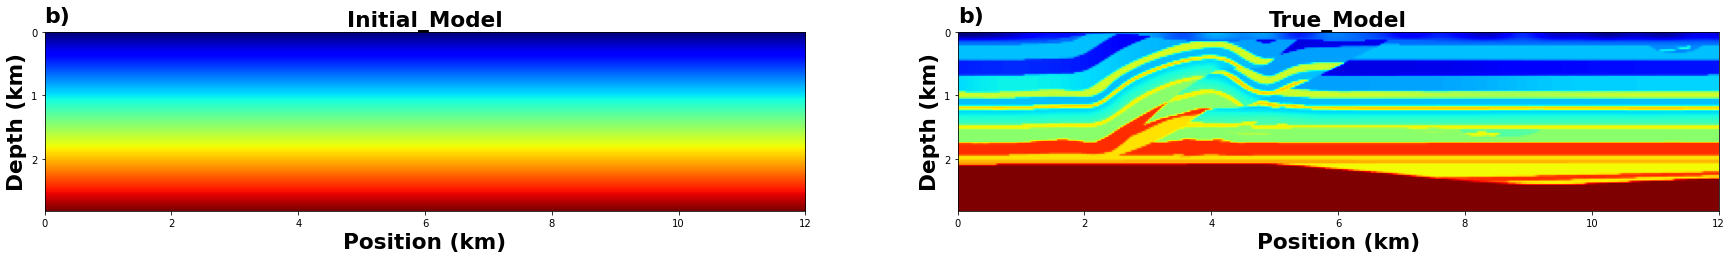

In [5]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3])
box_min = 2360
box_max = 6000

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx1 / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx1 / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [6]:
from torchsummary import summary
from Model.Module22 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 10


### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim_s, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(1,nt,num_receivers_per_shot),(1,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 565
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1, 2000, 567]              10
         LeakyReLU-2         [-1, 1, 2000, 567]               0
            Conv2d-3         [-1, 2, 2000, 567]              20
         LeakyReLU-4         [-1, 2, 2000, 567]               0
            Conv2d-5         [-1, 2, 2000, 567]              20
         LeakyReLU-6         [-1, 2, 2000, 567]               0
            Conv2d-7         [-1, 4, 2000, 567]              40
         LeakyReLU-8         [-1, 4, 2000, 567]               0
            Conv2d-9         [-1, 4, 2000, 567]              40
        LeakyReLU-10         [-1, 4, 2000, 567]               0
           Conv2d-11         [-1, 2, 2000, 567]              20
        LeakyReLU-12         [-1, 2, 2000, 567]               0
           Conv2d-13         [-1, 1, 2000, 567]              10
        Leak

## Main SiameseFWI

In [7]:
 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR






t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)

        # Prepare the data for Siamese network.
        d_real = batch_rcv_amps_true.permute(1,0,2)
        d_real = d_real.unsqueeze(1)
        # train with fake data
        d_fake = batch_rcv_amps_pred.permute(1,0,2)
        d_fake = d_fake.unsqueeze(1)
        disc_fake, disc_real, o1, o2 = netD(d_fake,d_real)
        # Measure the Eculedian Loss.
        loss =   F.pairwise_distance(o1, o2, keepdim = True).mean()

        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 100 FWI iterations .
    if (i>0) and (i%200==0):
        scheduler.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  0.2549637014667193 lr_DL: 1e-06 lr_vel: 80 SNR: 17.427830912928112 SSIM: 0.046952873
Epoch: 2 Loss:  0.2128858615954717 lr_DL: 1e-06 lr_vel: 80 SNR: 17.221712580249605 SSIM: 0.05166131
Epoch: 3 Loss:  0.19940580129623414 lr_DL: 1e-06 lr_vel: 80 SNR: 16.98712823052216 SSIM: 0.062039115
Epoch: 4 Loss:  0.19270853052536646 lr_DL: 1e-06 lr_vel: 80 SNR: 16.823336756989434 SSIM: 0.06375052
Epoch: 5 Loss:  0.19276578774054845 lr_DL: 1e-06 lr_vel: 80 SNR: 16.88743883157848 SSIM: 0.07568432
Epoch: 6 Loss:  0.19086138506730396 lr_DL: 1e-06 lr_vel: 80 SNR: 16.71940367610371 SSIM: 0.09394214
Epoch: 7 Loss:  0.18560894628365834 lr_DL: 1e-06 lr_vel: 80 SNR: 16.705614270997767 SSIM: 0.11299824
Epoch: 8 Loss:  0.18237162232398987 lr_DL: 1e-06 lr_vel: 80 SNR: 16.617591460331266 SSIM: 0.11450108
Epoch: 9 Loss:  0.1834998627503713 lr_DL: 1e-06 lr_vel: 80 SNR: 16.64334147953895 SSIM: 0.1284822
Epoch: 10 Loss:  0.18095881789922713 lr_DL: 1e-06 lr_vel: 80 SNR: 16.60364614540871 SSIM: 0.12608

Epoch: 83 Loss:  0.14092660695314407 lr_DL: 1e-06 lr_vel: 80 SNR: 16.555091015503727 SSIM: 0.37684393
Epoch: 84 Loss:  0.1419843167066574 lr_DL: 1e-06 lr_vel: 80 SNR: 16.598169205868707 SSIM: 0.37664402
Epoch: 85 Loss:  0.1461867223183314 lr_DL: 1e-06 lr_vel: 80 SNR: 16.64620886148755 SSIM: 0.3798662
Epoch: 86 Loss:  0.14715647051731745 lr_DL: 1e-06 lr_vel: 80 SNR: 16.60661388603312 SSIM: 0.37624958
Epoch: 87 Loss:  0.14612966602047284 lr_DL: 1e-06 lr_vel: 80 SNR: 16.65405112382937 SSIM: 0.3858451
Epoch: 88 Loss:  0.13879917487502097 lr_DL: 1e-06 lr_vel: 80 SNR: 16.698989751964866 SSIM: 0.39196393
Epoch: 89 Loss:  0.14085045109192532 lr_DL: 1e-06 lr_vel: 80 SNR: 16.7284771071571 SSIM: 0.39762887
Epoch: 90 Loss:  0.1375355377793312 lr_DL: 1e-06 lr_vel: 80 SNR: 16.811079852873203 SSIM: 0.41075766
Epoch: 91 Loss:  0.13656918729345005 lr_DL: 1e-06 lr_vel: 80 SNR: 16.806518753420086 SSIM: 0.41028768
Epoch: 92 Loss:  0.13972254594167074 lr_DL: 1e-06 lr_vel: 80 SNR: 16.910798459727726 SSIM: 0

Epoch: 164 Loss:  0.12165951505303382 lr_DL: 1e-06 lr_vel: 80 SNR: 19.332260898158914 SSIM: 0.526308
Epoch: 165 Loss:  0.11989271591107051 lr_DL: 1e-06 lr_vel: 80 SNR: 19.41988757061996 SSIM: 0.5303401
Epoch: 166 Loss:  0.11181562369068464 lr_DL: 1e-06 lr_vel: 80 SNR: 19.476013740971965 SSIM: 0.5327947
Epoch: 167 Loss:  0.1139680340886116 lr_DL: 1e-06 lr_vel: 80 SNR: 19.577949360155532 SSIM: 0.5324648
Epoch: 168 Loss:  0.11452133705218633 lr_DL: 1e-06 lr_vel: 80 SNR: 19.684288464065776 SSIM: 0.5362278
Epoch: 169 Loss:  0.11199159572521845 lr_DL: 1e-06 lr_vel: 80 SNR: 19.802078355196397 SSIM: 0.5361929
Epoch: 170 Loss:  0.11731658230225245 lr_DL: 1e-06 lr_vel: 80 SNR: 19.8215651697182 SSIM: 0.52954775
Epoch: 171 Loss:  0.115090927730004 lr_DL: 1e-06 lr_vel: 80 SNR: 19.922217398613668 SSIM: 0.5354497
Epoch: 172 Loss:  0.10997568567593892 lr_DL: 1e-06 lr_vel: 80 SNR: 20.02550801591303 SSIM: 0.537757
Epoch: 173 Loss:  0.11731334601839384 lr_DL: 1e-06 lr_vel: 80 SNR: 20.1082310008073 SSIM: 

Epoch: 239 Loss:  0.09982723407447339 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.218524744419366 SSIM: 0.5383606
Epoch: 240 Loss:  0.10035331199566523 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.198570074542737 SSIM: 0.53587675
Epoch: 241 Loss:  0.09881762477258842 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.2344883688263 SSIM: 0.5398569
Epoch: 242 Loss:  0.09121196245153745 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.29218022504646 SSIM: 0.54165363
Epoch: 243 Loss:  0.09545883846779664 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.263841147701918 SSIM: 0.5377562
Epoch: 244 Loss:  0.09407198218007883 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.256730984884555 SSIM: 0.53812486
Epoch: 245 Loss:  0.09733206033706665 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.21550568707618 SSIM: 0.5370802
Epoch: 246 Loss:  0.0936929759879907 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.245761315650647 SSIM: 0.5402264
Epoch: 247 Loss:  0.093179377540946 lr_DL: 9.9999999999999

Epoch: 309 Loss:  0.046057627474268274 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.583062729802048 SSIM: 0.5574607
Epoch: 310 Loss:  0.04535859984656175 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.514054616696917 SSIM: 0.55094635
Epoch: 311 Loss:  0.04695051622887452 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.574192223636963 SSIM: 0.55175024
Epoch: 312 Loss:  0.04486961116393407 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.593781538751387 SSIM: 0.5538106
Epoch: 313 Loss:  0.04596644223978122 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.504005020216738 SSIM: 0.5502553
Epoch: 314 Loss:  0.04613760765641928 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.55598305355406 SSIM: 0.5541193
Epoch: 315 Loss:  0.0424306221306324 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.58446515125032 SSIM: 0.5534627
Epoch: 316 Loss:  0.04076420838634173 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.578341859249086 SSIM: 0.55447483
Epoch: 317 Loss:  0.039532046454648175 lr_DL: 9.9999999

Epoch: 379 Loss:  0.013988608463356892 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.848425319486662 SSIM: 0.56997174
Epoch: 380 Loss:  0.014814417498807112 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.808095869876993 SSIM: 0.56781936
Epoch: 381 Loss:  0.014099529789139828 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.846692575292376 SSIM: 0.57329816
Epoch: 382 Loss:  0.014357004516447584 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.849549464520443 SSIM: 0.5711762
Epoch: 383 Loss:  0.014160143025219441 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.866654681658545 SSIM: 0.5732657
Epoch: 384 Loss:  0.013414552171404163 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.846306559340334 SSIM: 0.57367736
Epoch: 385 Loss:  0.013909658199797075 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.87855246949936 SSIM: 0.57295626
Epoch: 386 Loss:  0.014376269994924466 lr_DL: 9.999999999999999e-06 lr_vel: 80 SNR: 22.846184500935816 SSIM: 0.5718131
Epoch: 387 Loss:  0.01343424200701217 lr_DL:

Epoch: 448 Loss:  0.003946816618554294 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.18581650738198 SSIM: 0.5903586
Epoch: 449 Loss:  0.003488663281314075 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.19278332507878 SSIM: 0.5916226
Epoch: 450 Loss:  0.0035856475199883184 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.193170880687283 SSIM: 0.59099436
Epoch: 451 Loss:  0.0033864611526951195 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.207615527024778 SSIM: 0.5928748
Epoch: 452 Loss:  0.0031977511631945768 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.219920692008124 SSIM: 0.59393007
Epoch: 453 Loss:  0.0032864301620672146 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.201195864043243 SSIM: 0.59284264
Epoch: 454 Loss:  0.0034992752984787027 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.210891261473453 SSIM: 0.59282875
Epoch: 455 Loss:  0.0032855442414681116 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.226064259775193 SSIM: 0.59352666
Epoch: 456 Loss:  0.0032158650069807966

Epoch: 517 Loss:  0.0010229851565478991 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.53722318078836 SSIM: 0.62150586
Epoch: 518 Loss:  0.0009462700283620507 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.54555071077459 SSIM: 0.6223665
Epoch: 519 Loss:  0.0010250372831554463 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.55022863992625 SSIM: 0.62298095
Epoch: 520 Loss:  0.0009731827061235284 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.549929546159657 SSIM: 0.623003
Epoch: 521 Loss:  0.0009200465574394912 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.56173478388679 SSIM: 0.6239953
Epoch: 522 Loss:  0.0008917624334571883 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.564574417683794 SSIM: 0.6245416
Epoch: 523 Loss:  0.0008501620031893253 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.575305233855314 SSIM: 0.62559193
Epoch: 524 Loss:  0.0007953222850725675 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.572849554477664 SSIM: 0.62569875
Epoch: 525 Loss:  0.0008500227937474847 l

Epoch: 586 Loss:  0.00015002960960070293 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.908560086345794 SSIM: 0.65895075
Epoch: 587 Loss:  0.00016351581531732034 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.911877494143937 SSIM: 0.6590503
Epoch: 588 Loss:  0.00017891341558424757 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.915096366164917 SSIM: 0.65944916
Epoch: 589 Loss:  0.0001600028966398289 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.92163100407938 SSIM: 0.6597514
Epoch: 590 Loss:  0.0001594755985327841 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.92719014170785 SSIM: 0.6601901
Epoch: 591 Loss:  0.0002757470288391536 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.925419679198434 SSIM: 0.65962964
Epoch: 592 Loss:  0.00016998795108520427 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.936496987828004 SSIM: 0.6606004
Epoch: 593 Loss:  0.00015214442052335168 lr_DL: 9.999999999999999e-05 lr_vel: 80 SNR: 23.940278817532963 SSIM: 0.6610123
Epoch: 594 Loss:  0.00014906108626

Epoch: 663 Loss:  0.00010348522943483355 lr_DL: 0.001 lr_vel: 80 SNR: 24.168554379321698 SSIM: 0.6720734
Epoch: 664 Loss:  0.0003087579270262116 lr_DL: 0.001 lr_vel: 80 SNR: 24.15706661100053 SSIM: 0.6709998
Epoch: 665 Loss:  0.00017228163026932936 lr_DL: 0.001 lr_vel: 80 SNR: 24.1692486629036 SSIM: 0.67181206
Epoch: 666 Loss:  9.78576438986541e-05 lr_DL: 0.001 lr_vel: 80 SNR: 24.174710544522068 SSIM: 0.67228925
Epoch: 667 Loss:  0.00010556967972661369 lr_DL: 0.001 lr_vel: 80 SNR: 24.177920659285412 SSIM: 0.67244035
Epoch: 668 Loss:  0.00031668280813998233 lr_DL: 0.001 lr_vel: 80 SNR: 24.165424616831984 SSIM: 0.67115724
Epoch: 669 Loss:  0.00019489391294579643 lr_DL: 0.001 lr_vel: 80 SNR: 24.179257995426383 SSIM: 0.6720324
Epoch: 670 Loss:  0.0001043459555755059 lr_DL: 0.001 lr_vel: 80 SNR: 24.18636125781916 SSIM: 0.6726926
Epoch: 671 Loss:  0.00010843526336733097 lr_DL: 0.001 lr_vel: 80 SNR: 24.184310235107695 SSIM: 0.6727449
Epoch: 672 Loss:  0.00021827690773837578 lr_DL: 0.001 lr_ve

Epoch: 742 Loss:  0.0001342652981596378 lr_DL: 0.001 lr_vel: 80 SNR: 24.35810839738825 SSIM: 0.6799277
Epoch: 743 Loss:  0.00011179626380908303 lr_DL: 0.001 lr_vel: 80 SNR: 24.364411195451055 SSIM: 0.68039185
Epoch: 744 Loss:  8.0234673320471e-05 lr_DL: 0.001 lr_vel: 80 SNR: 24.36750253713096 SSIM: 0.6807541
Epoch: 745 Loss:  7.205271273657369e-05 lr_DL: 0.001 lr_vel: 80 SNR: 24.369224273719283 SSIM: 0.6808417
Epoch: 746 Loss:  0.00010597422624414321 lr_DL: 0.001 lr_vel: 80 SNR: 24.360395124794515 SSIM: 0.68044436
Epoch: 747 Loss:  0.0003319777587118248 lr_DL: 0.001 lr_vel: 80 SNR: 24.352430234153392 SSIM: 0.6791788
Epoch: 748 Loss:  0.00015654864085566563 lr_DL: 0.001 lr_vel: 80 SNR: 24.36661457909212 SSIM: 0.6796683
Epoch: 749 Loss:  7.878875088257094e-05 lr_DL: 0.001 lr_vel: 80 SNR: 24.374801851578436 SSIM: 0.6805218
Epoch: 750 Loss:  7.2514111889177e-05 lr_DL: 0.001 lr_vel: 80 SNR: 24.377860780110055 SSIM: 0.6809142
Epoch: 751 Loss:  7.041388635116163e-05 lr_DL: 0.001 lr_vel: 80 SN

## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


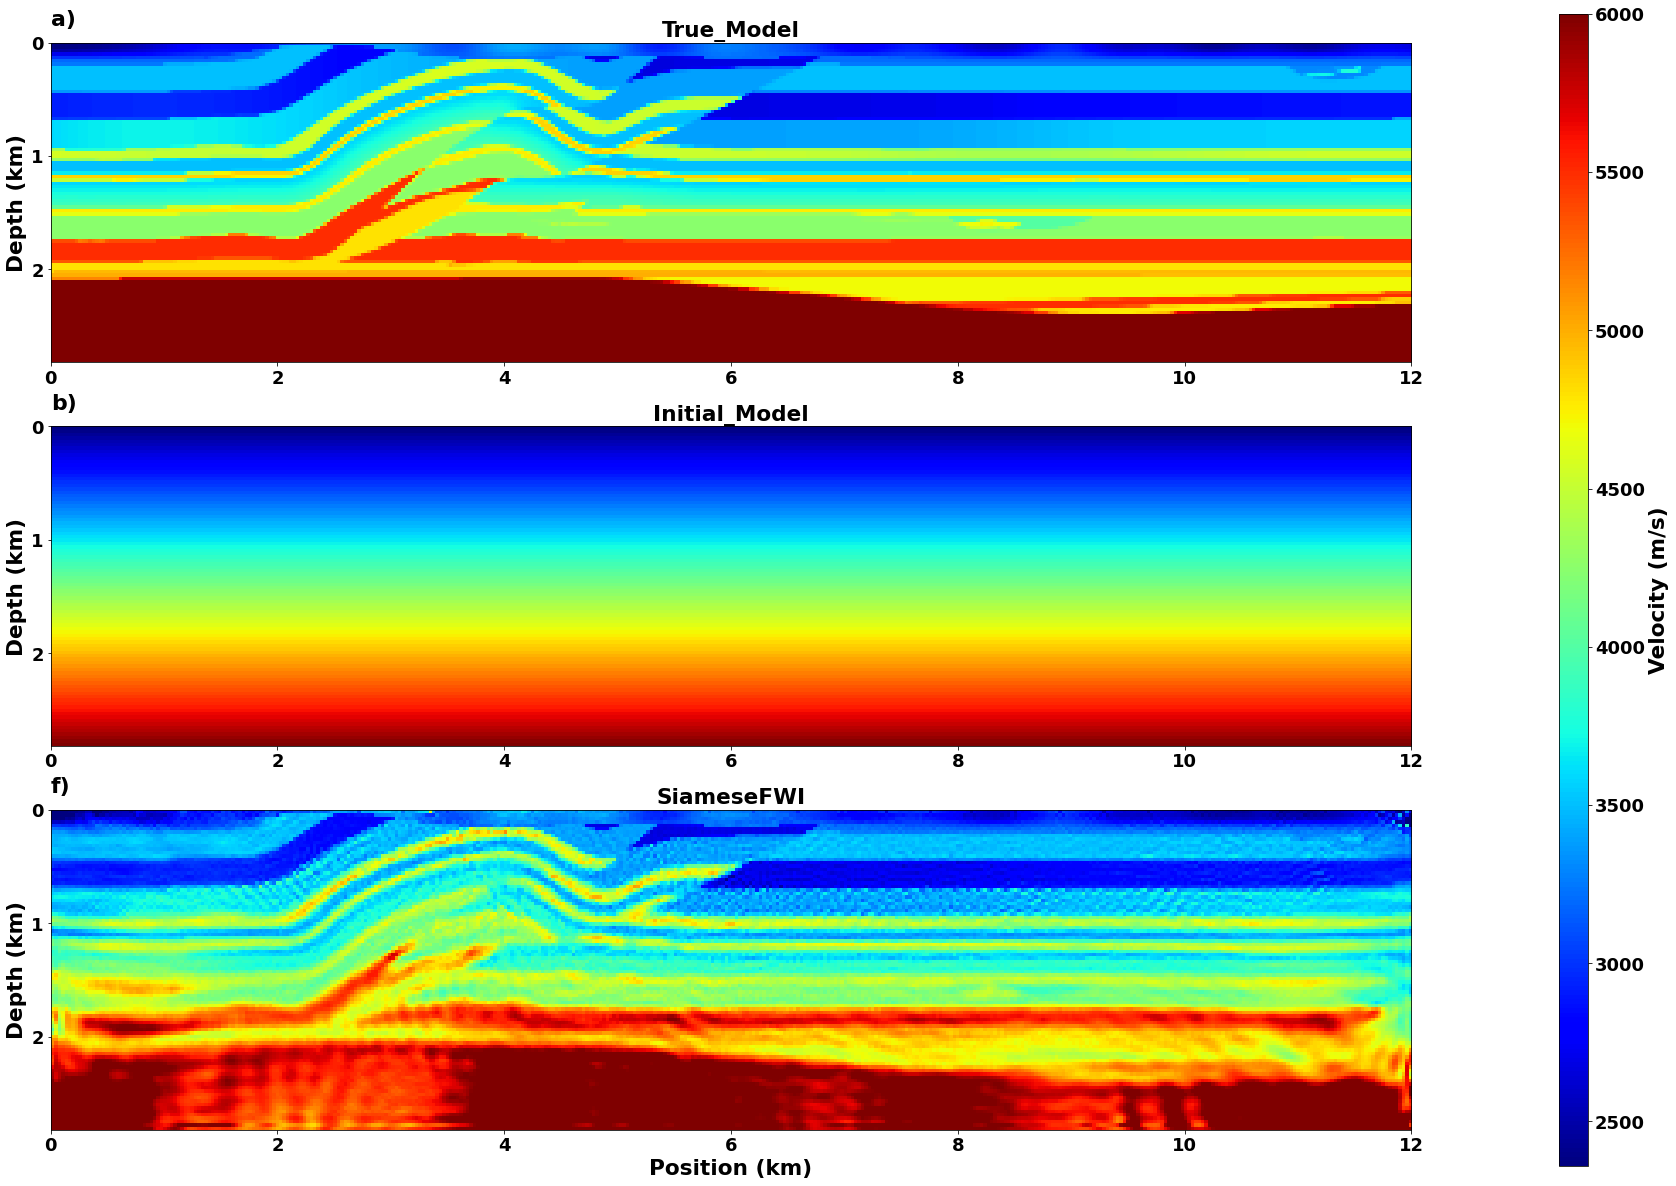

The reconstructed velocity model has SNR: 24.420666429053522 dB and SSIM: 0.6813324


In [8]:

f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx1 / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx1 / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx1 / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

## Plotting Velocities Profiles

In [ ]:
#torch.save(netD.state_dict(), fwi_result + 'netD')
#netD = torch.load(fwi_result + 'netD')
#netD